In [1]:
import warnings, gc
import numpy as np 
import pandas as pd
import matplotlib.colors
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
import matplotlib.pyplot as plt

import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE



c:\Users\wianc\anaconda3\envs\MasterEnv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\wianc\anaconda3\envs\MasterEnv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# EDA, Feature Engineering and identifying economic regimes

# Inspect the data - What are the features, what is the target?
# Compare data to the papers data - Do we have the same features in ours?
# Evaluate missing values within the data - Do you replace or remove?

# Transform the data - Normalise/scale, fill in missing values (Look at Probabilistic PCA or LGBMImputer)

# Use PCA or something to discern the most important features - both training and target variables.

# EDA, Feature Engineering and economic indicators
### This file serves as a starting point towards identifying economic regimes.
### Broadly speaking, this file consists of the following:

##### - Inspect the data - What are the features, what is the target?
##### - Compare data to the papers data - Do we have the same features in ours?
##### - Evaluate missing values within the data - Do you replace or remove?
##### - Transform the data - Normalise/scale, fill in missing values (Look at Probabilistic PCA or LGBMImputer)
##### - Use PCA or something to discern the most important features - both training and target variables.

###### (Feel free to add as we go along)

In [3]:
# Read in and construct the initial dataset.

def createDataset(csv):
    temp_ds = pd.read_csv(csv)
    temp_ds.date = pd.to_datetime(temp_ds.date, format="%Y/%m/%d")
    temp_ds = temp_ds.set_index('date')
    print(temp_ds.shape)
    return temp_ds



# Define folder path of source data
folder_path = "C:/Users/Wian/Desktop/Economic Data/"
folder_path = "C:/Users/wianC/Desktop/NMRQL/Economic Data/"






# Read in description files
annual_desc = pd.read_csv(folder_path + 'annually_description_file.csv')
month_desc = pd.read_csv(folder_path + 'monthly_description_file.csv')
quarterly_desc = pd.read_csv(folder_path + 'quarterly_description_file.csv')

# Read in data files
annual_data = createDataset(folder_path + 'us_economics_annually.csv')
quarterly_data = createDataset(folder_path + 'us_economics_quarterly.csv')
monthly_data = createDataset(folder_path + 'us_economics_monthly.csv')






# Concatenate all data together (with an outer join)
concat_data = pd.concat([monthly_data, quarterly_data, annual_data], axis = 1, join='outer')

# Check that column ids (descriptions references) do not overlap between the different datasets we concatennated.
if len(concat_data.columns.unique()) < len(concat_data.columns): print("Duplicated columns present in data!")

# Check for any categorical data - The datasets are all float, hinting that there is none... Still need to verify though.
print("Dataframe unique dtypes: ", np.unique(list(concat_data.dtypes)))

concat_data

(62, 174)
(250, 442)
(751, 429)
Dataframe unique dtypes:  [dtype('float64')]


,43677,43678,43679,43680,43681,43682,43685,43686,43688,43689,...,77431,77433,79838,79841,79843,79845,79848,79851,79853,80572
date,,,,,,,,,,,,,,,,,,,,,
1960-02-01,2.99,496.0,NaN,10.8,NaN,NaN,202.0,NaN,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03-01,0.82,-264.0,NaN,10.8,NaN,NaN,250.0,NaN,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04-01,1.88,1843.0,NaN,10.8,NaN,NaN,274.0,NaN,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05-01,2.01,892.0,NaN,10.8,NaN,NaN,366.0,NaN,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-06-01,2.07,946.0,NaN,10.8,NaN,NaN,368.0,NaN,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,NaN,-115.0,129127.872953,124.7,27.27,33.8,-106806.0,-101069.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01,NaN,618.0,129256.098450,125.4,27.42,34.3,-104040.0,-108384.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-01,NaN,69.0,NaN,125.6,27.27,34.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


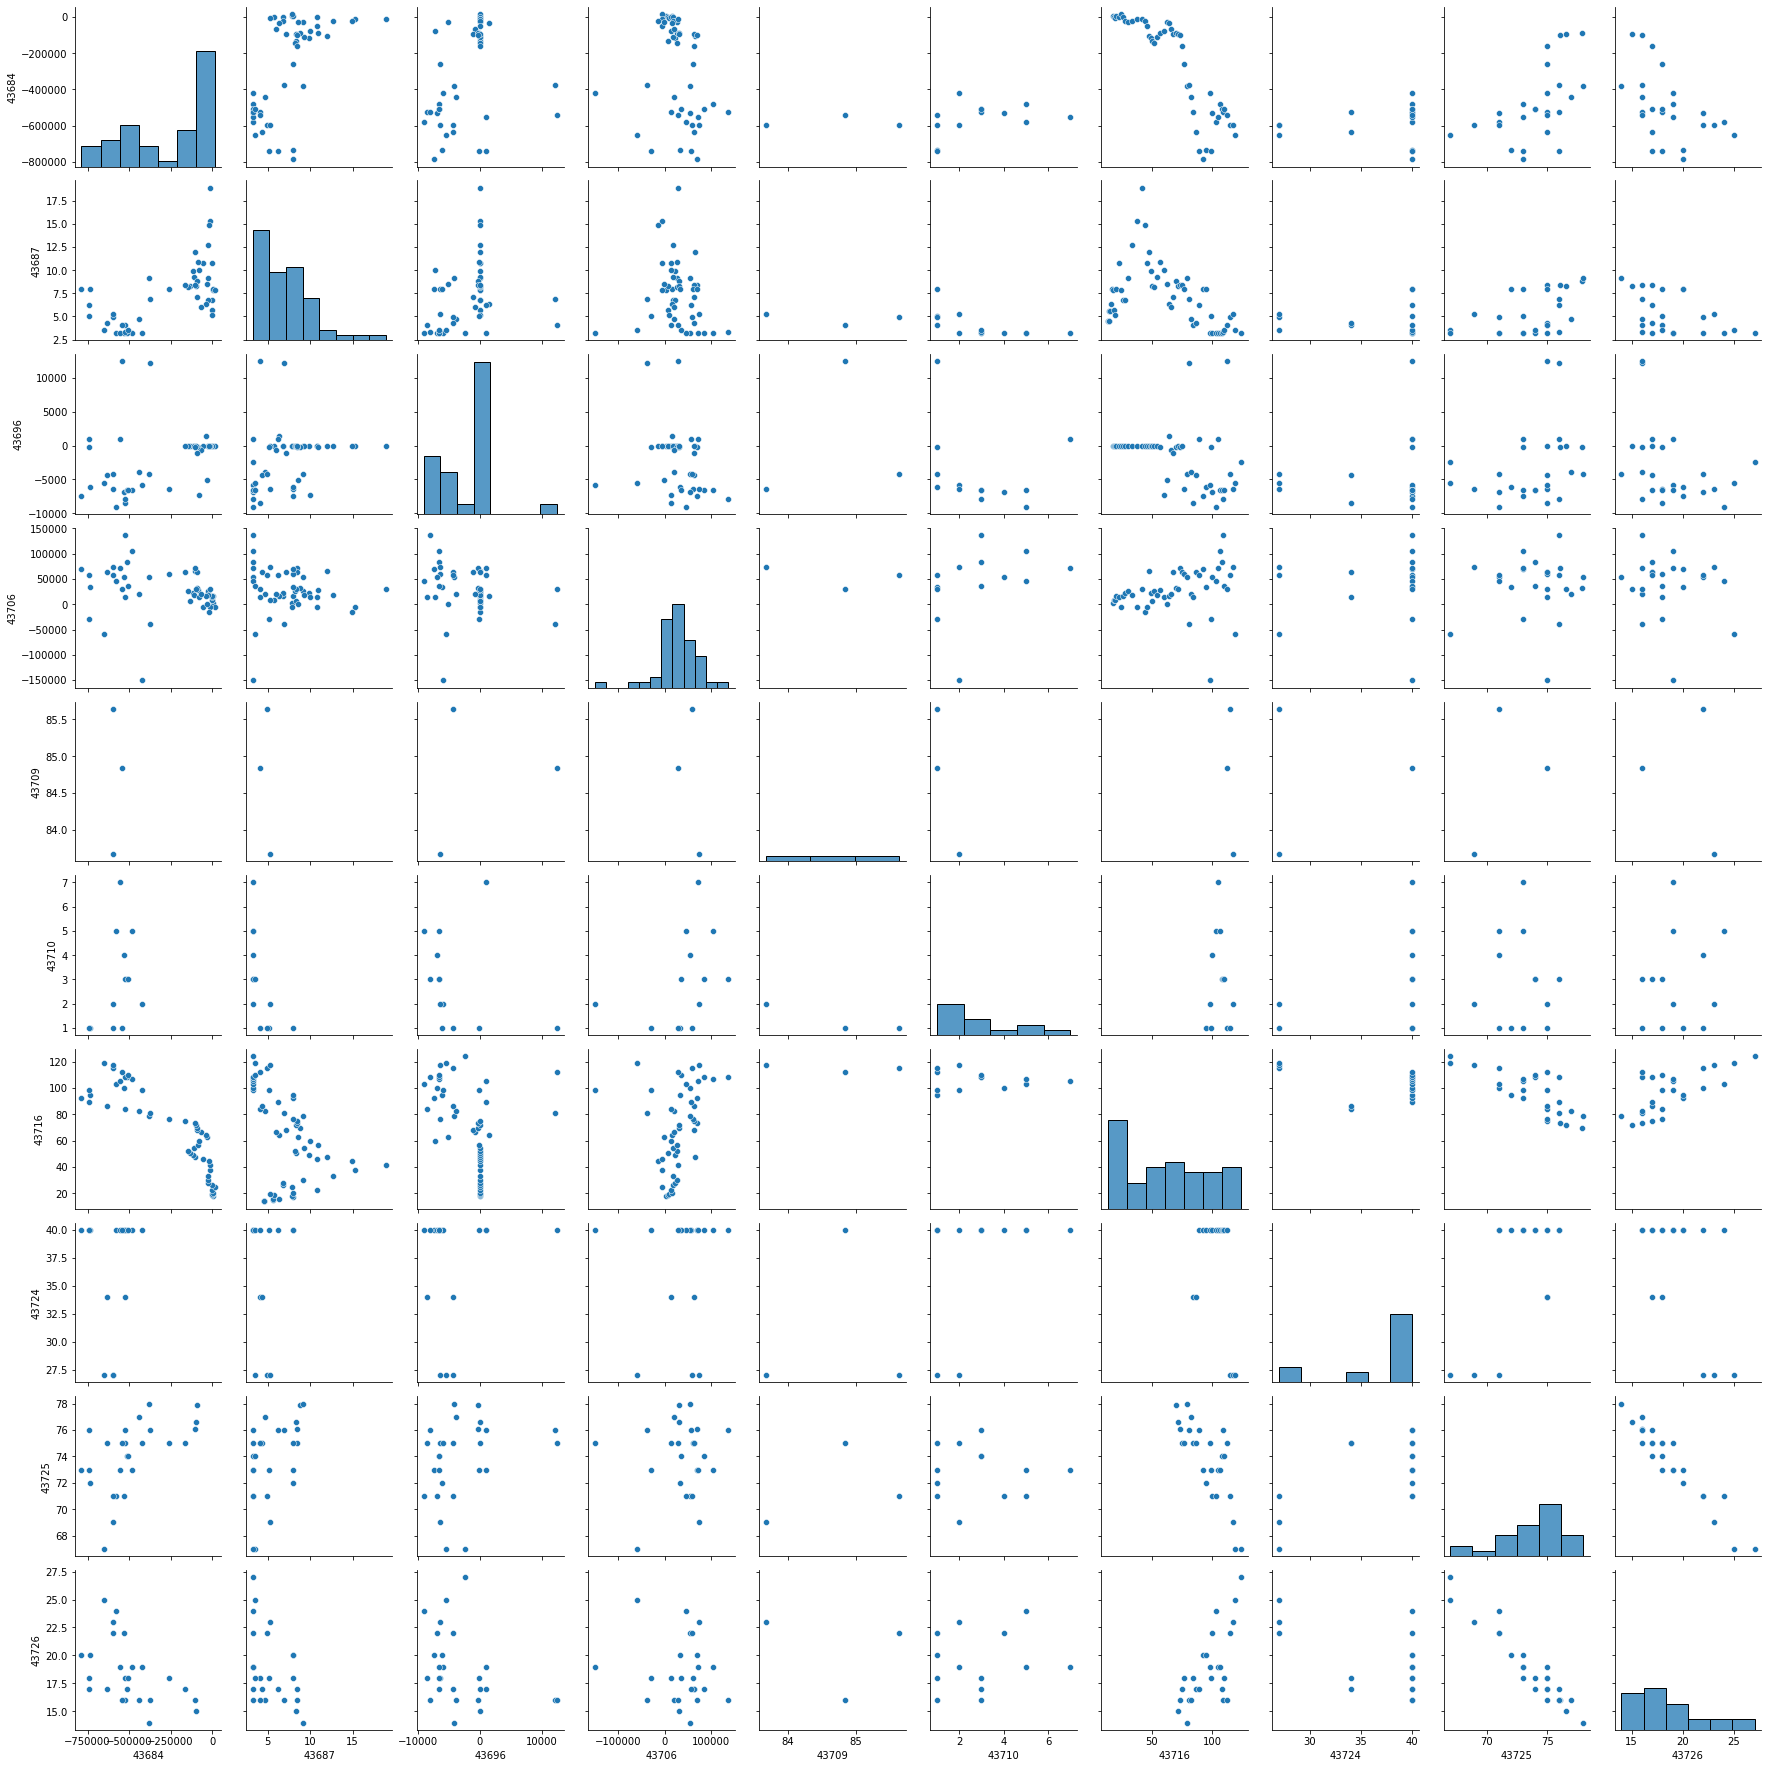

In [4]:
# Have a quick look at the correlations etc between the first 10 annual variables as a pairplot.

sns.pairplot(annual_data.iloc[:,:10])

# There's simply too many variables to use a pairplot for all variables, 
# but what we can see is that several variables are not normally distributed
# and that there are both linear and non-linear correlations in the data.

#### There are numerous NaN values. Most are as a result of data not reported as far back as other data, from resampling yearly to quarterly intervals as well as some missing intermediate values.

##### We will remove variables that are both too recent, and too old.
##### We will impute missing NaN values for both missing interval values and reampled NaN data.

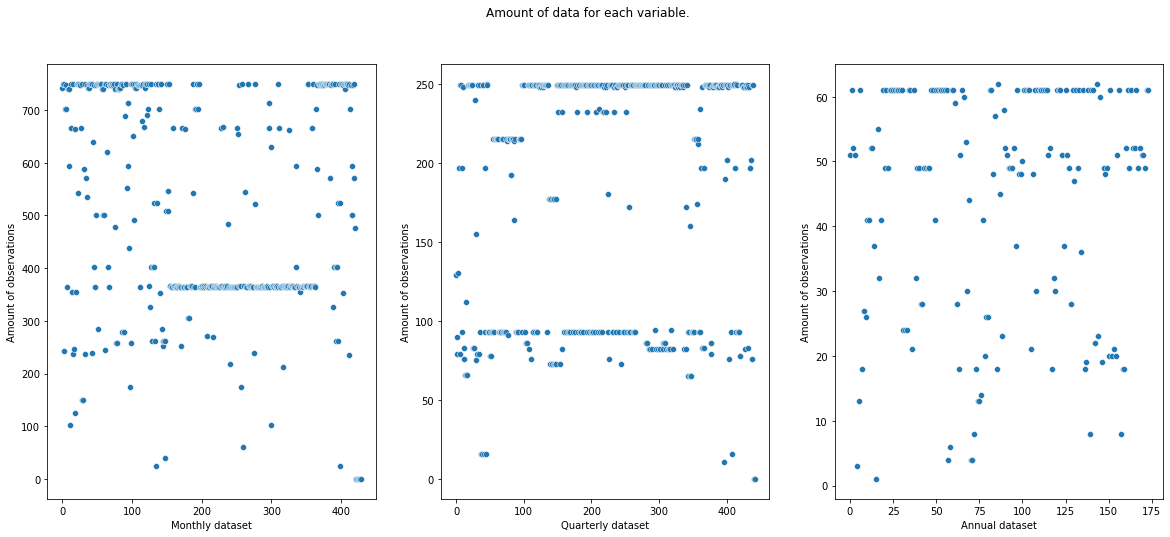

In [5]:
# Display the amount of observations (Excluding NaNs) in the data.

def displayAmountOfData(ds, ds_name, axes, index):
    temp_list = list()
    for col in ds:
        temp_list.append(len(ds[col].dropna()))

    sns.scatterplot(x = range(len(ds.columns)), y = temp_list, ax = axes[index])
    axes[index].set_ylabel("Amount of observations")
    axes[index].set_xlabel(ds_name)
    plt.ylabel('Amount of observations')
    plt.xlabel(ds_name)


fig, axes = plt.subplots(1,3, figsize = (20,8))
plt.suptitle("Amount of data for each variable.")
displayAmountOfData(monthly_data, 'Monthly dataset', axes, 0)
displayAmountOfData(quarterly_data, 'Quarterly dataset', axes, 1)
displayAmountOfData(annual_data, 'Annual dataset', axes, 2)

# There are numerous variables with large amounts of NaN values - We'll need to discern wether to keep those variables.

These variables did not have any entries:  ['90835', '90836', '90837', '90838', '90839', '90840', '90841', '90842']

These variables did not have any entries:  ['90833', '90834']

These variables did not have any entries:  []



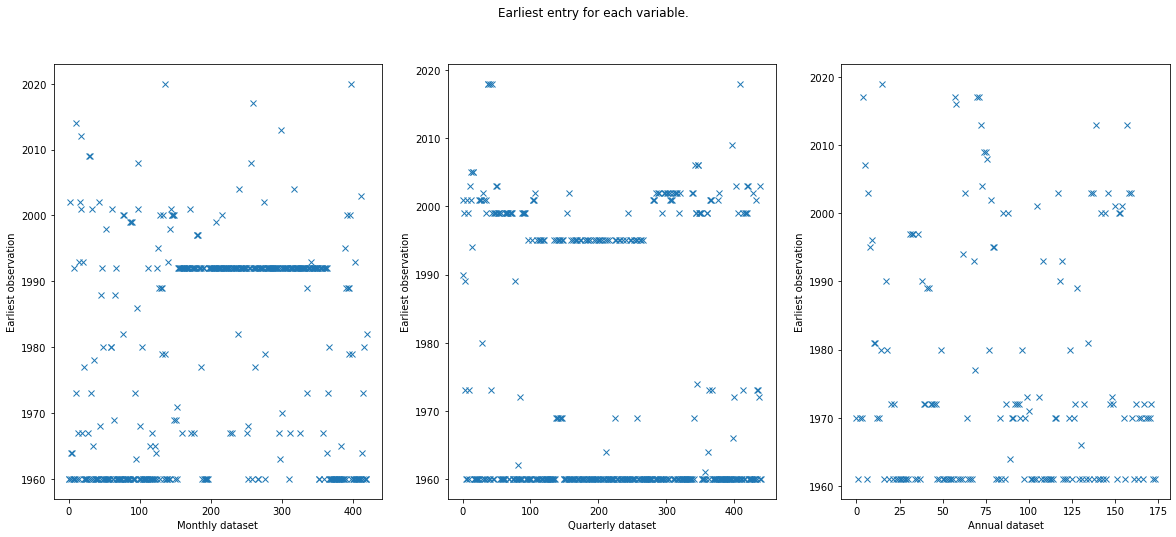

In [6]:
# Display the earliest non-NaN entry for each variable in the dataset.

def displayEarliestEntry(ds, ds_name, axes, index):
    temp_list = list()
    emptycolumns = list()
    for col in ds:
        if len(ds[col].dropna()) == 0:
            emptycolumns.append(col)
        else: 
            temp_list.append(ds[col].dropna().index.to_numpy().min().astype('datetime64[Y]').astype(int) + 1970)

    print("These variables did not have any entries: ", emptycolumns)
    print()

    axes[index].plot(temp_list, 'x')
    axes[index].set_ylabel("Earliest observation")
    axes[index].set_xlabel(ds_name)

fig, axes = plt.subplots(1,3, figsize = (20,8))
plt.suptitle("Earliest entry for each variable.")
displayEarliestEntry(monthly_data, 'Monthly dataset', axes, 0)
displayEarliestEntry(quarterly_data, 'Quarterly dataset', axes, 1)
displayEarliestEntry(annual_data, 'Annual dataset', axes, 2)

# We see that the majority of variables are from around 1960's for all three different datasets. 
# Furthermore, there seems to be numerous variables that started in the early nineties, and lesser so at the turn of the millenium.
# Lastly, there are 10 variables that do not contain any observations at all. This is strange, and should be checked later on.



These variables did not have any entries:  ['90835', '90836', '90837', '90838', '90839', '90840', '90841', '90842']

These variables did not have any entries:  ['90833', '90834']

These variables did not have any entries:  []



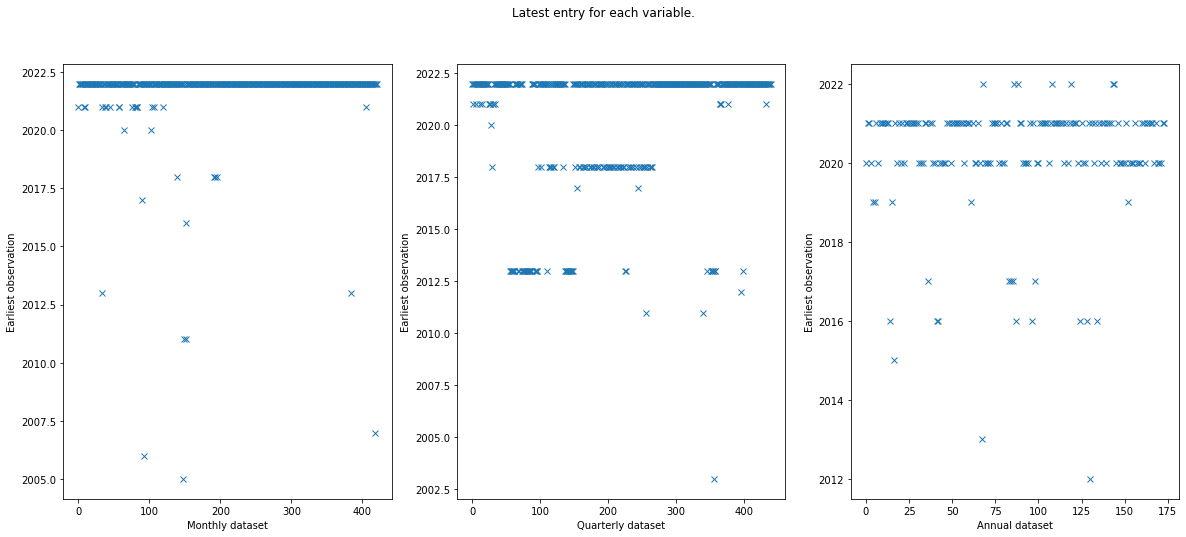

In [7]:
# Display the latest non-NaN entry for each variable in the dataset.


def displayLatestEntry(ds, ds_name, axes, index):
    temp_list = list()
    emptycolumns = list()
    for col in ds:
        if len(ds[col].dropna()) == 0:
            emptycolumns.append(col)
        else: 
            temp_list.append(ds[col].dropna().index.to_numpy().max().astype('datetime64[Y]').astype(int) + 1970)

    print("These variables did not have any entries: ", emptycolumns)
    print()

    axes[index].plot(temp_list, 'x')
    axes[index].set_ylabel("Earliest observation")
    axes[index].set_xlabel(ds_name)

fig, axes = plt.subplots(1,3, figsize = (20,8))
plt.suptitle("Latest entry for each variable.")
displayLatestEntry(monthly_data, 'Monthly dataset', axes, 0)
displayLatestEntry(quarterly_data, 'Quarterly dataset', axes, 1)
displayLatestEntry(annual_data, 'Annual dataset', axes, 2)


# We see that the majority of variables end within the past 3 years for all three datasets. 

C:\Users\wianc\AppData\Local\Temp\ipykernel_18752\4021633979.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  firstYear = np.str(ds[col].dropna().index.to_numpy().min().astype('datetime64[Y]').astype(int) + 1970)
C:\Users\wianc\AppData\Local\Temp\ipykernel_18752\4021633979.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lastYear = np.str(ds[col].d

Text(0.5, 0.98, 'Percentage of missing (intermediate) data')

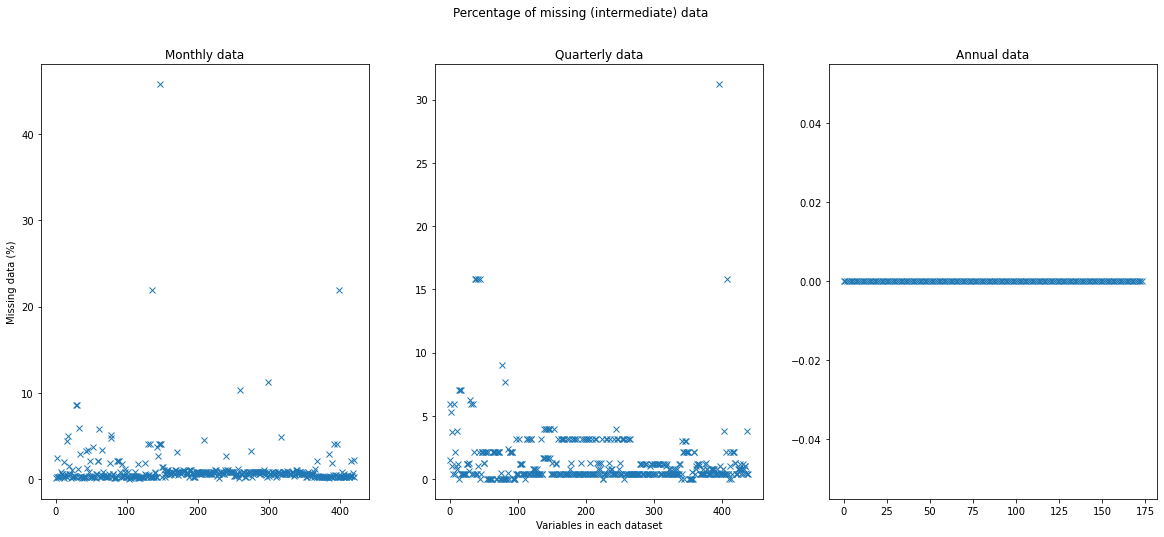

In [8]:
# Display the percentage of intermediary NaN values for each dataset.

def function(dataset):

    ds = dataset.copy()
    lists = list()
    emptycolumns = list()
    for col in ds:
        if len(ds[col].dropna()) == 0:
            emptycolumns.append(col)
        else: 
            firstYear = np.str(ds[col].dropna().index.to_numpy().min().astype('datetime64[Y]').astype(int) + 1970)
            lastYear = np.str(ds[col].dropna().index.to_numpy().max().astype('datetime64[Y]').astype(int) + 1970)
            percentageMissing = ds[col][firstYear : lastYear].isna().sum() / len(ds[col][firstYear : lastYear]) * 100
            lists.append(percentageMissing)

    return lists


fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (20,8))
 
ax0.plot(function(monthly_data), 'x')
ax0.set_title("Monthly data")

ax1.plot(function(quarterly_data), 'x')
ax1.set_title('Quarterly data')

ax2.plot(function(annual_data), 'x')
ax2.set_title('Annual data')

ax0.set_ylabel('Missing data (%)')
ax1.set_xlabel('Variables in each dataset')
plt.suptitle("Percentage of missing (intermediate) data")




# Why are these values missing? Are they as a result of holidays? Tragedies (Market closes)? 
# Are the fact that some are missing actually valuable to the other variables?
# Do we need to remove the high percentage NaN variables?

### We want quarterly data, so let's resample and prepare the data

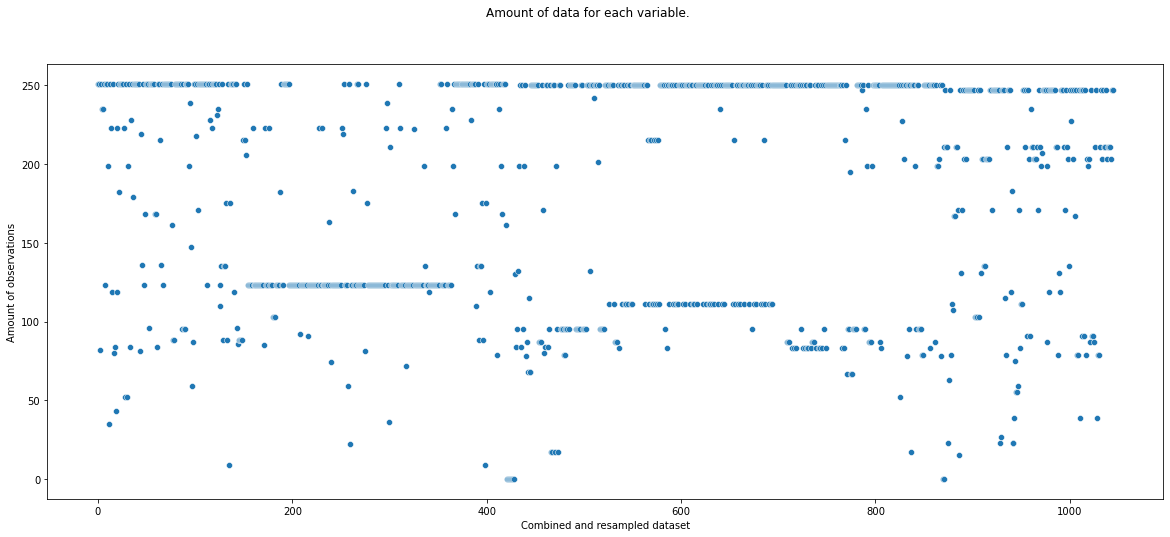

In [9]:
# Downsample the monthly data to quarterly data by taking the mean, then linearly interpolate and ffill the ramaining data.
# Then show the amount of data.

def displayAmountOfData(ds, ds_name, axes, index):
    temp_list = list()
    for col in ds:
        temp_list.append(len(ds[col].dropna()))

    sns.scatterplot(x = range(len(ds.columns)), y = temp_list, ax = axes)
    axes.set_ylabel("Amount of observations")
    axes.set_xlabel(ds_name)
    plt.ylabel('Amount of observations')
    plt.xlabel(ds_name)



# Perform resampling as well as inter- and extrapolation on the dataset.
temp_ds = concat_data.resample(rule='Q', label='right').mean().interpolate('linear').ffill()



fig, axes = plt.subplots(1,1, figsize = (20,8))
plt.suptitle("Amount of data for each variable.")
displayAmountOfData(temp_ds, 'Combined and resampled dataset', axes, 0)

## Removing variables using a threshold.

Dropped 651
Remaining:  -257


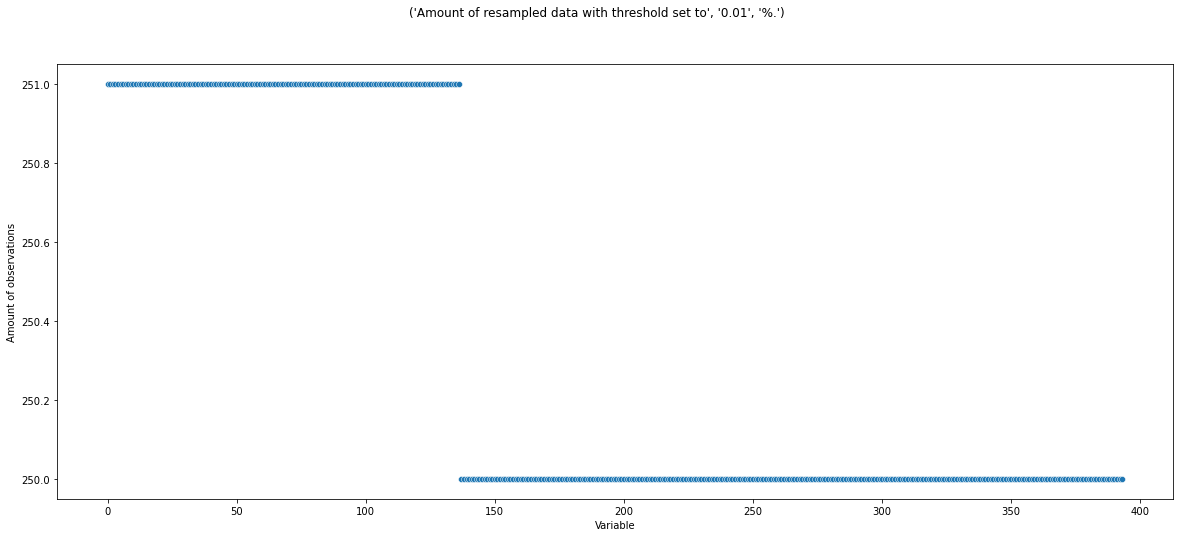

In [10]:
# Let's have a threshold that removes variables that do not have enough data.
# If threshold is set to 10% (0.1) then variables with more than 10% NaN values are dropped from the dataset.

def thresholdData(data_ds, axes, threshold):

    temp_ds = data_ds.copy()
    count = 0
    for col in temp_ds.columns:
        if temp_ds[col].isna().sum()/len(temp_ds[col]) > threshold:
            temp_ds.drop(col, axis = 1, inplace=True)
            count = count + 1
    print("Dropped" , count)
    print("Remaining: ", len(temp_ds.columns) - count)

    return temp_ds



# Create new data dataset based on threshold value
threshold = 0.01
raw_ds = thresholdData(temp_ds, axes, threshold)


# Create description dataset based on new threshold data dataset
all_desc = pd.concat((month_desc, quarterly_desc, annual_desc))
temp_list = list()
for match in raw_ds.columns:
    temp_list.append(all_desc[all_desc['series_id'] == int(match)])
raw_desc = pd.DataFrame(np.reshape(temp_list, (394,2)), columns=all_desc.columns)



fig, axes = plt.subplots(1,1, figsize = (20,8))
plt.suptitle(("Amount of resampled data with threshold set to", str(threshold),"%."))

temp_list = list()
for col in raw_ds:
    temp_list.append(len(raw_ds[col].dropna()))

sns.scatterplot(x = range(len(raw_ds.columns)), y = temp_list, ax = axes)
axes.set_ylabel("Amount of observations")
axes.set_xlabel('Variable')
plt.ylabel('Amount of observations')
plt.xlabel('Variable')


# When the threshold is set to 5%, we lose about 55% of the variables.

raw_ds = raw_ds['1961':'2021']
# Finally, remove the last year of observations (2022), thus all variables have 250 observations.

In [11]:
# What are other Exploratory Data Analysis approaches we can do?
# There may be too much training variables to do Distribution plots (like Violinplots) 

## Setting up a one target variable

In [12]:
# Let's find a suitable target variable.
# Here we get a target list that contains all matched signals from the joined datasets.
# Note - There can be duplicates, this code doesn't cater towards such cases but should be addressed in future setups.

indicatorList = ['Industrial Production']

all_desc = pd.concat((month_desc, quarterly_desc, annual_desc))

temp_dict = dict() 
for i in range(len(all_desc)):
    temp_dict[i] = np.array(all_desc['description'])[i]

for indicator in indicatorList:
    matches = [match for match in temp_dict.values() if indicator in match]
    print(indicator)
    print("There are", len(matches), " matches for ", indicator, ":")

print()
print('Description/s of the matches:')
print()
targets = list()
for match in np.unique(matches):
    print(match)
    targets.append(all_desc.loc[lambda all_desc: all_desc['description'] == match][:1])

print()
print('Location/s:')
print(targets)

Industrial Production
There are 13  matches for  Industrial Production :

Description/s of the matches:

United States: Industrial Output, Industrial Production Index, Total Index (2012), SA - United States [US: Industrial Production Index (IPI-12): sa]
United States: Industrial Production Growth (%) [US: Industrial Production Index (IPI-12): PCTCHG: ANNUAL]
United States: Industrial Production Growth (%) [US: Industrial Production Index (IPI-12): PCTCHG: QUARTERLYN]
United States: Industrial Production Growth (%) [US: Industrial Production Index (IPI-12): PCTCHG]
United States: Industrial Production Index Growth [US: Industrial Production Index (IPI-12): PCTCHG]
United States: Industrial Production Index Growth [US: Industrial Production Index (IPI-97): PCTCHG]
United States: Industrial Production Mom [Growth rate: PoP: Industrial production: (sa): United States]
United States: Industrial Production Mom [US: Industrial Production Index (IPI-12): PCTCHG_1]
United States: Industrial Pro

In [13]:
# Assign the first match from the target list as the target variable (y_raw). 
# Remove the single target from the dataset:
# Removing the target is not actually desired, but for ease of this first bit of exploration, I ommit the target variable from the training dataset.
# (Note, there may be other signals in the training dataset that have extremely high correlation to the target, and should be ommitted in future code as well)

# Note - I hardcode here the target (Choosing a percentage change variable to easy correlation investigations) - Industrial Production Growth (%) [US: Industrial Production Index (IPI-12): PCTCHG: QUARTERLYN]
target = targets[2]

y_raw = np.array(raw_ds[str(target.series_id.values[0])])
print("Taking the following single variable as our target: ")
print(target)

# Drop from training set
X_raw = raw_ds.drop(str(target.series_id.values[0]), axis = 1)

# Drop Date index
X_raw = X_raw.reset_index().drop('date', axis = 1)
X_raw




Taking the following single variable as our target: 
    series_id                                        description
30      63407  United States: Industrial Production Growth (%...


,43677,43678,43680,43685,43688,43689,43694,43701,43712,43717,...,75566,75567,75573,75781,77432,77434,79840,79844,80573,80605
0,0.796667,-195.666667,10.900000,538.000000,4.50,4.50,98.500000,71.600000,100.666667,13.670000,...,-1.044963,-1.044963,133.9,334.5,1131.0,-151.0,21.6,715.0,52.71,52.71
1,-0.573333,817.000000,11.066667,445.000000,4.50,4.50,100.833333,77.233333,101.100000,13.670000,...,-1.833532,-1.833532,136.7,339.5,607.0,-403.0,22.2,542.0,52.00,52.00
2,-0.576667,-371.666667,11.066667,398.000000,4.50,4.50,101.666667,79.533333,101.266667,13.743333,...,-1.228594,-1.228594,139.5,342.3,522.0,162.0,22.5,625.0,51.71,51.71
3,0.213333,-168.333333,11.266667,439.333333,4.50,4.50,101.933333,86.633333,101.233333,13.760000,...,-0.106047,-0.106047,144.0,349.6,573.0,-597.0,23.0,461.0,50.99,50.99
4,1.113333,-36.666667,11.400000,388.666667,4.50,4.50,101.633333,90.033333,101.433333,13.786667,...,1.303403,1.303403,146.3,354.8,886.0,145.0,23.8,452.0,49.84,49.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,-5.513333,605.666667,116.033333,-82635.333333,3.25,3.25,101.233333,49.566667,99.100000,119.400000,...,-5.896400,-5.896400,6072.3,14467.6,-323918.0,-134626.0,772.2,-51261.0,129.19,129.19
240,-4.623333,293.333333,117.333333,-87334.000000,3.25,3.25,101.766667,49.133333,99.333333,120.683333,...,-4.045664,-4.045664,6301.8,15005.4,-174919.0,-11234.0,796.6,18555.0,127.65,127.65
241,10.143333,596.666667,118.733333,-87922.333333,3.25,3.25,101.766667,51.733333,99.766667,123.506667,...,10.717565,10.717565,6577.0,15681.7,-134372.0,74917.0,805.8,70249.0,125.45,125.45
242,4.866667,581.000000,120.600000,-89719.333333,3.25,3.25,101.600000,41.266667,98.600000,125.486667,...,5.473718,5.473718,6779.4,15964.9,-203231.0,47019.0,819.2,-58910.0,122.53,122.53


In [14]:
# Create a Train-Test Split dataset and scale each (85/15 split).

split = 0.85
X_train = X_raw.iloc[:int(len(X_raw)*split),:]
X_test = X_raw.iloc[int(len(X_raw)*split):,:]

y_train = y_raw[:int(len(y_raw)*split)]
y_test = y_raw[int(len(y_raw)*split):]

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)




# After the split, perform scaling. (Note, this assumes data is somewhat normal distributed, which is likely not the case or all columns/variables)
scaler = MinMaxScaler()

X_train_scl = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scl = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

y_train_scl = (y_train - y_train.mean())/y_train.std()
y_test_scl = (y_test - y_test.mean())/y_test.std()

(207, 393)
(207,)

(37, 393)
(37,)


## Let's try linear regression with only one (highly correlated) dependent variable.

In [15]:
# Visually find a sufficiently high correlated variable.
print(raw_ds.corr()[str(target.series_id.values[0])].sort_values()[-10:-1])

print()
temp_indep = '63404'
print("Description of dependent variable: ")
print(all_desc[all_desc['series_id'] == int(temp_indep)]['description'])

temp_dep = str(target.series_id.values[0])

temp_ds = pd.DataFrame((raw_ds[str(target.series_id.values[0])], raw_ds[temp_indep])).transpose()

# For dependent variable 63407 (Industrial Growth (%)), we chose 63404 (Real GDP Growth (%)) as the independent 

63404    0.890133
45998    0.890172
70894    0.890172
46013    0.921584
75576    1.000000
63407    1.000000
63406    1.000000
63496         NaN
79854         NaN
Name: 63407, dtype: float64

Description of dependent variable: 
27    United States: Real GDP Growth (%) [US: Gross ...
Name: description, dtype: object


<AxesSubplot:>

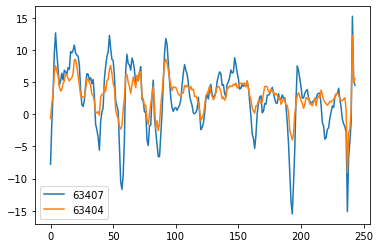

In [16]:
temp_ds.reset_index().drop('date', axis = 1).plot()

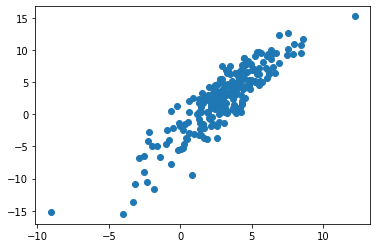

In [17]:
# We see the two variables are indeed somewhat linearly correlated.

#plt.scatter(x = temp_ds.reset_index().drop('date', axis = 1)['43677'], y = temp_ds.reset_index().drop('date', axis = 1)['63407'])
plt.scatter(x = temp_ds.reset_index().drop('date', axis = 1)[temp_indep], y = temp_ds.reset_index().drop('date', axis = 1)[temp_dep])

In [20]:
# First do a simple linear regression model, assume data is not autocorrelated (Time-series)

# All of these imports are the result of lazy copy pasting packages from some earlier projects of mine... Not all is needed.

from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Input, Activation, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout, Embedding, LSTM, MaxPool2D, BatchNormalization, Concatenate 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import normalize as nrml
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG19, ResNet50, MobileNetV2, VGG16, InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.layers import UpSampling2D, concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model       
import tensorflow as tf
import tensorflow_datasets as tfds


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler



# Thought:
# Perhaps transform all of the economic data to percentage gains, otherwise the correlations could be misleading.

ModuleNotFoundError: No module named 'tensorflow'

In [256]:
# Create a simple regression network.

model = Sequential()
model.add(Input(shape = (1,)))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))
model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                20        
_________________________________________________________________
dense_16 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [257]:
history = model.fit(
    X_train_scl[temp_indep],
    y_train_scl,
    epochs=100,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

test_results = model.evaluate(X_test_scl[temp_indep], y_test_scl, verbose=1)
test_results


2/2 [==============================] - 0s 3ms/step - loss: 0.1980 - mean_absolute_error: 0.3758


[0.19801819324493408, 0.3758046627044678]

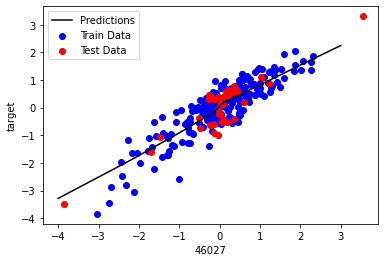

In [259]:
def plot_model_results(x, y):
  plt.scatter(X_train_scl[temp_indep], y_train_scl, label='Train Data', color = 'b')
  plt.scatter(X_test_scl[temp_indep], y_test_scl, label='Test Data', color = 'r')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel(temp_train)
  plt.ylabel('target')
  plt.legend()

x = np.linspace(-4,3,30)
y = model.predict(x)
plot_model_results(x,y)

## XGBoost with multiple features.

In [18]:
# Create a Train-Test Split dataset for the newtork training.

split = 0.85
X_train = X_raw.iloc[:int(len(X_raw)*split),:]
X_test = X_raw.iloc[int(len(X_raw)*split):,:]

y_train = y_raw[:int(len(y_raw)*split)]
y_test = y_raw[int(len(y_raw)*split):]

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

# After the split, perform scaling. - Could do this before the split to simplify the code

scaler = MinMaxScaler()
X_train_scl = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

X_test_scl = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

y_train_scl = (y_train - y_train.mean())/y_train.std()
y_test_scl = (y_test - y_test.mean())/y_test.std()

X_train_XG = np.array(X_train_scl['43677'])
X_test_XG = np.array(X_test_scl['43677'])
y_train_XG = y_train_scl
y_test_XG = y_test_scl



(207, 393)
(207,)

(37, 393)
(37,)


In [19]:
# Find the best params

xgb_r = xg.XGBRegressor(objective = 'reg:squarederror', eval_metric = 'rmse', seed = 42)

param_grid = {"max_depth" : [4,5,6],
              "n_estimators": [50, 100, 300, 500, 700],
              "learning_rate": [0.01, 0.015, 0.02]}

search = GridSearchCV(xgb_r, param_grid=param_grid, cv = 5).fit(X_train_scl, y_train_scl)

print("The best hyperparamters are: ", search.best_params_)

c:\Users\wianc\anaconda3\envs\MasterEnv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\wianc\anaconda3\envs\MasterEnv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\wianc\anaconda3\envs\MasterEnv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\wianc\anaconda3\envs\MasterEnv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Ind

The best hyperparamters are:  {'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 700}


In [21]:
regressor = xg.XGBRegressor(learning_rate = search.best_params_['learning_rate'],
                             n_estimators = search.best_params_['n_estimators'],
                             max_depth = search.best_params_['max_depth'],
                             eval_metric = 'rmse')

regressor.fit(X_train_scl, y_train_scl)
predictions = regressor.predict(X_test_scl)

In [22]:
RMSE = np.sqrt(mean_squared_error(y_test_scl, predictions) )
print("The score is %.5f" % RMSE )

The score is 1.17174


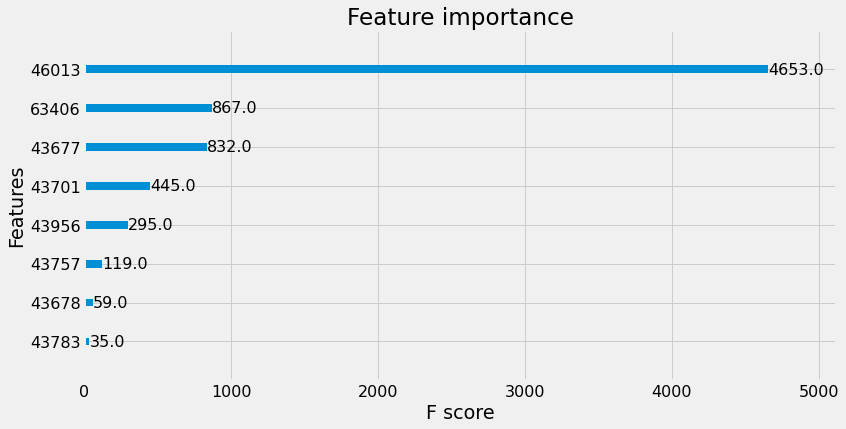

In [23]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show()

In [24]:
# The most "Important" feature used by XGBoost is:
 
list(all_desc.loc[lambda all_desc: all_desc['series_id'] == 46013]['description'])[0]

'United States: Industrial Production Index Growth [US: Industrial Production Index (IPI-97): PCTCHG]'

## Use PCA to reduce dimension with XGBoost

(0.0, 17.0)

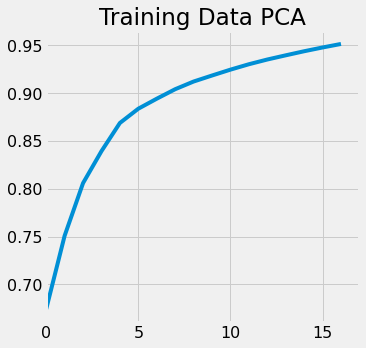

In [32]:
fig, ax0 = plt.subplots(1,1, figsize = (5,5))

pca = PCA(n_components=0.95)
pca.fit_transform(X_train_scl)

X_train_PCA = pca.transform(X_train_scl)
X_test_PCA = pca.transform(X_test_scl)


ax0.plot(pca.explained_variance_ratio_.cumsum()[:len(pca.explained_variance_ratio_)])
ax0.set_title("Training Data PCA")
ax0.grid(True)
ax0.set_xlim(0, len(pca.explained_variance_ratio_))

In [33]:
xgb_r = xg.XGBRegressor(objective = 'reg:squarederror', eval_metric = 'rmse', seed = 42)

param_grid = {"max_depth" : [4,5,6],
              "n_estimators": [50,100,300, 500, 700],
              "learning_rate": [0.01, 0.015, 0.02]}


search = GridSearchCV(xgb_r, param_grid=param_grid, cv = 5).fit(X_train_PCA, y_train_scl)

print("The best hyperparamters are: ", search.best_params_)

The best hyperparamters are:  {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 500}


In [34]:
regressor = xg.XGBRegressor(learning_rate = search.best_params_['learning_rate'],
                             n_estimators = search.best_params_['n_estimators'],
                             max_depth = search.best_params_['max_depth'],
                             eval_metric = 'rmse')

regressor.fit(X_train_PCA, y_train_scl)
predictions = regressor.predict(X_test_PCA)

In [35]:
RMSE = np.sqrt(mean_squared_error(y_test_scl, predictions) )
print("The score is %.5f" % RMSE )

The score is 0.68366


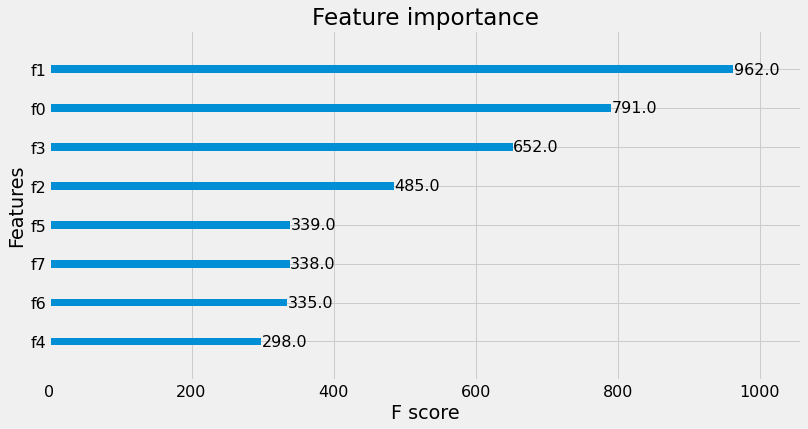

In [36]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show()

## Set up multiple targets (with PCA) and put lagged targets back into training data.

In [251]:
# Let's find a suitable target variable - Store in "target" variable.
# Note - I checked matches for 'Business Cycle', and they're ommitted from the dataset as they do not have enough datapoints.

indicatorList = ['Industrial Production']

indicatorList = ['Inflation']



# Create description dataset (raw_desc) based on threshold data dataset (raw_ds)
all_desc = pd.concat((month_desc, quarterly_desc, annual_desc))
temp_list = list()
for match in raw_ds.columns:
    temp_list.append(all_desc[all_desc['series_id'] == int(match)])
raw_desc = pd.DataFrame(np.reshape(temp_list, (394,2)), columns=all_desc.columns)


temp_dict = dict()
for i in range(len(all_desc)):
    temp_dict[i] = np.array(all_desc['description'])[i]

temp_array = temp_dict.values()
for indicator in indicatorList:
    matches = [match for match in temp_array if indicator in match]
    print(indicator)
    print("There are originally ", len(matches), " matches for ", indicator, ":")

print()
print('Description/s:')
print()
targets = list()
temp_ids = list()
for match in matches:
    print(match)
    temp_ids.append(list(all_desc.loc[lambda all_desc: all_desc['description'] == match]['series_id'])[0])


Inflation
There are originally  16  matches for  Inflation :

Description/s:

United States: Long-Term Bond Yield (%) [US: Treasury Constant Maturity Yield: Inflation Indexed: Average: Long-term Average]
United States: Core Inflation Rate [Inflation rate: YoY: CPI: Excluding food and energy: United States]
United States: Food Inflation [Inflation rate: YoY: CPI: Food & non-alcoholic beverages: United States]
United States: Food Inflation [US: CPI-U-82/84: FB: Food]
United States: Food Inflation [US: CPI-U-82/84: FB: Food: PCTCHG_1]
United States: Inflation Rate [US: CPI: All Urban Consumers (CPI-U-82/84): All Items: PCTCHG_1]
United States: Inflation Rate [US: CPI: All Urban Consumers (CPI-U-82/84): All Items: PCTCHG_2]
United States: Inflation Rate Mom [Inflation rate: PoP: CPI: All items: United States]
United States: Inflation Rate Mom [US: CPI: All Urban Consumers (CPI-U-82/84): All Items: PCTCHG_3]
United States: 10-Year Breakeven Inflation Rate [US: Inflation Rate: 10-Year Breake

In [313]:
target_ids = [str(id) for id in temp_ids if str(id) in raw_ds.columns]

print("With thresholding, there are", len(target_ids), "matches left: ")
print([all_desc[all_desc['series_id'] == int(id)] for id in target_ids])


# For the 'Inflation' indicator the amount of matches reduced from 16 to 8. We can now calculate the Principal Components for these targets

With thresholding, there are 8 matches left: 
[    series_id                                        description
84      43723  United States: Core Inflation Rate [Inflation ...,      series_id                                        description
124      43776  United States: Food Inflation [Inflation rate:...,      series_id                                        description
125      43777  United States: Food Inflation [US: CPI-U-82/84...,      series_id                                        description
126      43778  United States: Food Inflation [US: CPI-U-82/84...,      series_id                                        description
170      43859  United States: Inflation Rate [US: CPI: All Ur...,      series_id                                        description
172      43862  United States: Inflation Rate [US: CPI: All Ur...,      series_id                                        description
173      43864  United States: Inflation Rate Mom [Inflation r...,      series_id          

In [304]:
# Put suitable target matches in dataframe
y_raw = pd.DataFrame(data = raw_ds[[str(id) for id in target_ids if str(id) in raw_ds.columns]])

# Remove target variables from the training data
X_raw = raw_ds.drop(target_ids, axis = 1)

# Adding lagged targets back into the dataset.
# I shift the targets by one quarter, hence we aim to predict one quarter into the future.
# Hence I remove the newly created NaN row from both the training and test set.
X_raw = pd.concat((X_raw, y_raw.shift(1)), axis = 1).dropna(axis = 0).reset_index().drop('date', axis = 1)
y_raw = y_raw.shift(1).dropna(axis = 0).reset_index().drop('date', axis = 1)

In [314]:
# Perform scaling (Subtract the mean and divide by the standard deviation for each column). 
# (Note, this assumes the data is normally distributed, which is likely not the case for these columns/variables.) For neural nets, we should instead do minmax transformation instead.

scaler = MinMaxScaler()

X_scl = pd.DataFrame(scaler.fit_transform(X_raw), columns = X_raw.columns)
y_scl = pd.DataFrame(scaler.fit_transform(y_raw), columns = y_raw.columns) #(y_raw - y_raw.mean())/y_raw.std()

(0.0, 7.0)

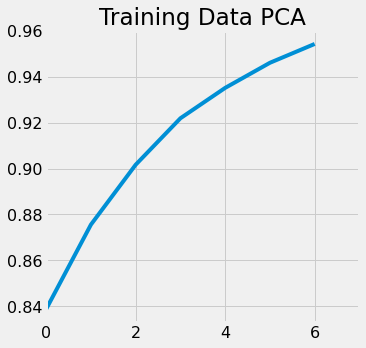

In [315]:
# Create PCAs for training datasets.

pca = PCA(n_components=0.95)
X_PCA = pca.fit_transform(X_scl)

fig, ax0 = plt.subplots(1,1, figsize = (5,5))
ax0.plot(pca.explained_variance_ratio_.cumsum()[:len(pca.explained_variance_ratio_)])
ax0.set_title("Training Data PCA")
ax0.grid(True)
ax0.set_xlim(0, len(pca.explained_variance_ratio_))


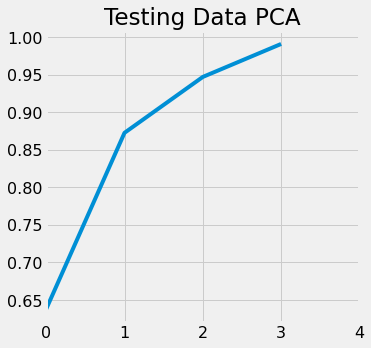

In [316]:
# Create PCAs for testing datasets
# Note - Base XGBoost does not handly multioutput targets, hence (for now) I only take the first PCA.

pca = PCA(n_components=1)
y_PCA = pca.fit_transform(y_scl)


fig, ax0 = plt.subplots(1,1, figsize = (5,5))
ax0.plot(pca.explained_variance_ratio_.cumsum()[:len(pca.explained_variance_ratio_)])
ax0.set_title("Testing Data PCA")
ax0.grid(True)
ax0.set_xlim(0, len(pca.explained_variance_ratio_))

In [317]:
# Split the data into train and test sets.
split = 0.85
X_train_PCA = X_PCA[:int(len(X_PCA)*split),:]
X_test_PCA = X_PCA[int(len(X_PCA)*split):,:]

y_train_PCA = y_PCA[:int(len(y_PCA)*split)]
y_test_PCA = y_PCA[int(len(y_PCA)*split):]

print(X_train_PCA.shape)
print(y_train_PCA.shape)
print()
print(X_test_PCA.shape)
print(y_test_PCA.shape)

(206, 7)
(206, 1)

(37, 7)
(37, 1)


In [318]:
xgb_r = xg.XGBRegressor(objective = 'reg:squarederror', eval_metric = 'rmse', seed = 42)

param_grid = {"max_depth" : [4,5,6],
              "n_estimators": [100,300, 500],
              "learning_rate": [0.01, 0.015, 0.02]}

search = GridSearchCV(xgb_r, param_grid=param_grid, cv = 5).fit(X_train_PCA, y_train_PCA)

print("The best hyperparamters are: ", search.best_params_)

The best hyperparamters are:  {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 500}


In [319]:
regressor = xg.XGBRegressor(learning_rate = search.best_params_['learning_rate'],
                             n_estimators = search.best_params_['n_estimators'],
                             max_depth = search.best_params_['max_depth'],
                             eval_metric = 'rmse')

regressor.fit(X_train_PCA, y_train_PCA)
predictions = regressor.predict(X_test_PCA)

RMSE = np.sqrt(mean_squared_error(y_test_PCA, predictions) )
print("The score is %.5f" % RMSE )


# The score improves (in comparison to only one target and not having lagged targets in the training data).

The score is 0.62407


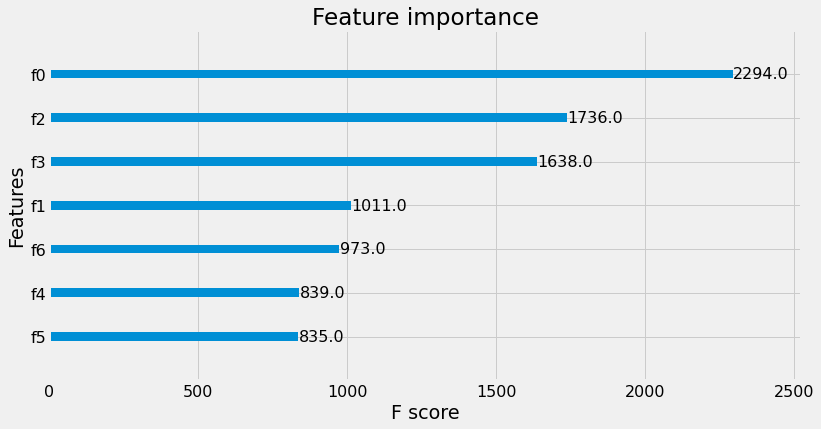

In [320]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show()

## Next Work

#### - Investigate other feature selection/engineering methods (Probabilistic PCA or LGBMImputer).
#### - Enable XGBoost to work for multioutput targets (instead of just one principal component target).
#### - Consider other models.
#### - Reframe the problem towards identifying economic regimes.

### Check how many variables match the economic indicators from JP Morgan.

In [28]:
indicatorList = ['ISM Manufacturing', 'Jobless Claims', 'US Leading Indicator', 'Global Leading Indicator',
                 'Leading-Lagging Economic Indicator Spread', 'Baltic Dry Index', 'Manufacturing New Orders', 
                 'New Housing', 'Consumer Sentiment', 'NAPM', 'CESI', 'Dow Transportation', 'Barclays', 
                 'Term Structure Momentum', 'Margin Debt Level', 'Loan Officers Survey', '10Y Bond Yield',
                 'Fed Fund Features', 'Avg Treasury Trading', 'Free Liquidity', 'Real Loan Growth', 'PPI', 
                 'Import Price Inflation', 'Breakeven Inflation', 'Commodity Price Index', 'ISM Non-manufacturing',
                 'Capacity Utilization', 'Yield Curve', 'Railroads Freight Index', 'World Stock Index', 
                 'Global Economic Momentum', 'Retail Sales', 'Credit Spread Moody', 'New Company Revisions', 
                 'JULI', 'VIX', 'Small-Large Cap', 'Barclays High Yield Spread', 'Stock Market', 'Margin Debt', 
                 'M2 Money Stock', 'Correlation of MZM SPX', 'USD Trade Weighted Index', 'US Credit Manager Index',
                 'Earnings Yield Dispersion', 'ISM Prices Index', 'Unit Labor Cost', 'Wage Trend Index', 'Oil Price',
                 'Median Home Price']

In [29]:
monthly_dict = dict() 
for i in range(len(month_desc)):
    monthly_dict[i] = np.array(month_desc['description'])[i].replace('United States: ', "")
monthly_array = monthly_dict.values()
monthly_dict

{0: 'ADP Employment Change [Pct Change: YoY: Employment, Persons:  United States]',
 1: 'ADP Employment Change [US: Employment: Total 16 Years & Over: DIFFERENCE_1]',
 2: 'ADP Employment Change [US: Employment: sa: Nonfarm Private Sector (PS)]',
 3: 'Average Monthly Wages ($) [US: Average Weekly Earnings (AWE): Private Nonfarm Payrolls (PNFP)]',
 4: 'Exchange Rate [US: Exchange Rate: Average: Euro]',
 5: 'Exchange Rate [US: Exchange Rate: Average: Euro]',
 6: 'Average Hourly Earnings [Hourly earnings index: Manufacturing: (sa): United States]',
 7: 'Average Hourly Earnings [US: Average Hourly Earnings (AHE): Private Nonfarm Payrolls (PNFP)]',
 8: 'Current Account Balance ($B) [BPM6: A. Current Account: MONTHLY]',
 9: 'Trade Balance (USD) [US: Trade Balance (Census Basis): Goods]',
 10: 'Consumer Price Index, Average [US: CPI: All Urban Consumers (CPI-U-82/84): All Items]',
 11: 'Trade Balance (USD) [US: Trade Balance (Census Basis): Goods]',
 12: 'Average Weekly Hours [US: Average Week

In [30]:
for indicator in indicatorList:
    matches = [match for match in monthly_array if indicator in match]
    print(indicator)
    print("There are", len(matches), " matches:")
    print(matches)
    print()

ISM Manufacturing
There are 2  matches:
['Manufacturing PMI [US: ISM Manufacturing: Purchasing Manager Index: sa]', 'Surveys and Diffusion Indexes, Manufacturing ISM Report on Business, PMI, SA - United States [US: ISM Manufacturing: Purchasing Manager Index: sa]']

Jobless Claims
There are 0  matches:
[]

US Leading Indicator
There are 0  matches:
[]

Global Leading Indicator
There are 0  matches:
[]

Leading-Lagging Economic Indicator Spread
There are 0  matches:
[]

Baltic Dry Index
There are 0  matches:
[]

Manufacturing New Orders
There are 0  matches:
[]

New Housing
There are 0  matches:
[]

Consumer Sentiment
There are 0  matches:
[]

NAPM
There are 0  matches:
[]

CESI
There are 0  matches:
[]

Dow Transportation
There are 0  matches:
[]

Barclays
There are 0  matches:
[]

Term Structure Momentum
There are 0  matches:
[]

Margin Debt Level
There are 0  matches:
[]

Loan Officers Survey
There are 0  matches:
[]

10Y Bond Yield
There are 0  matches:
[]

Fed Fund Features
There a

In [31]:
quarterly_dict = dict() 
for i in range(len(quarterly_desc)):
    quarterly_dict[i] = np.array(quarterly_desc['description'])[i].replace('United States: ', "")
quarterly_array = quarterly_dict.values()
quarterly_dict

{0: 'Average Monthly Wages ($) [US: Average Weekly Earnings (AWE): Private Nonfarm Payrolls (PNFP): QUARTERLYN]',
 1: 'GDP Deflator (2005=100) [US: Implicit Price Deflator (IPD-12): GDP: sa]',
 2: 'Current Account Balance ($B) [BPM6: A. Current Account]',
 3: 'Trade Balance ($B) [Net trade: (sa): QUARTERLYN]',
 4: 'Budget Expenditure / GDP (%) [General Govt: Operations Stmt: Expense [2]: * 100 /023_Q>> GDP]',
 5: 'Current Account Balance [US: BOP: Balance: Current Account (CA)]',
 6: 'Total Debt / GDP (%) [US: Gross External Debt (GED): Total: / 1000: * 100 / US.GDP.Q3_1.4]',
 7: 'Current Account Balance [US: BOP: Balance: Current Account (CA)]',
 8: 'Debt Interest Payment / GDP (%) [General Govt: Operations Stmt: Expense: Interest [24]: * 100 /023_Q>> GDP]',
 9: 'Bankruptcies [US: Bankruptcy Filings]',
 10: 'Budget Revenue (LCU B) ($B) [General Govt: Operations Stmt: Revenue [1]]',
 11: 'Banks Balance Sheet [Depository Corps: Net Foreign Assets]',
 12: 'Current Account Balance / GDP (

In [32]:
for indicator in indicatorList:
    matches = [match for match in quarterly_array if indicator in match]
    print(indicator)
    print("There are", len(matches), " matches:")
    print(matches)
    print()

ISM Manufacturing
There are 0  matches:
[]

Jobless Claims
There are 0  matches:
[]

US Leading Indicator
There are 0  matches:
[]

Global Leading Indicator
There are 0  matches:
[]

Leading-Lagging Economic Indicator Spread
There are 0  matches:
[]

Baltic Dry Index
There are 0  matches:
[]

Manufacturing New Orders
There are 0  matches:
[]

New Housing
There are 0  matches:
[]

Consumer Sentiment
There are 0  matches:
[]

NAPM
There are 0  matches:
[]

CESI
There are 0  matches:
[]

Dow Transportation
There are 0  matches:
[]

Barclays
There are 0  matches:
[]

Term Structure Momentum
There are 0  matches:
[]

Margin Debt Level
There are 0  matches:
[]

Loan Officers Survey
There are 0  matches:
[]

10Y Bond Yield
There are 0  matches:
[]

Fed Fund Features
There are 0  matches:
[]

Avg Treasury Trading
There are 0  matches:
[]

Free Liquidity
There are 0  matches:
[]

Real Loan Growth
There are 0  matches:
[]

PPI
There are 2  matches:
['Producer Prices Growth (%) [US: PPI-82: Finis

In [33]:
annual_dict = dict() 
for i in range(len(annual_desc)):
    annual_dict[i] = np.array(annual_desc['description'])[i].replace('United States: ', "")
annual_array = annual_dict.values()
annual_dict

{0: 'Average Monthly Wages ($) [US: Average Weekly Earnings (AWE): Private Nonfarm Payrolls (PNFP): ANNUAL]',
 1: 'Current Account Balance ($B) [BoP: Current account balance]',
 2: 'Trade Balance ($B) [National accounts: Local currency current prices: External balance on goods & services (EB)]',
 3: 'Domestic Credit Growth (%) [Net domestic credit: PCTCHG]',
 4: 'Balance Of Trade [National accounts: Local currency current prices: External balance on goods & services (EB)]',
 5: 'Budget Expenditure / GDP (%) [Government finance: Expenses: Total: * 100 /023_A>> GDP]',
 6: 'Total Debt / GDP (%) [US: Gross External Debt (GED): Total: ANNUAL: / 1000: * 100 / US.GDP.Q3_1.4.ANNUAL]',
 7: 'Bank Lending Rate [Interest rates: Lending interest rate]',
 8: 'Debt Interest Payment / GDP (%) [Government finance: Expenses: Interest payments: * 100 /023_A>> GDP]',
 9: 'Budget Revenue (LCU B) ($B) [Government finance: Revenue: Revenue, excluding grants]',
 10: 'Current Account Balance / GDP (%) [BoP: Cu

In [34]:
for indicator in indicatorList:
    matches = [match for match in quarterly_array if indicator in match]
    print(indicator)
    print("There are", len(matches), " matches:")
    print(matches)
    print()

ISM Manufacturing
There are 0  matches:
[]

Jobless Claims
There are 0  matches:
[]

US Leading Indicator
There are 0  matches:
[]

Global Leading Indicator
There are 0  matches:
[]

Leading-Lagging Economic Indicator Spread
There are 0  matches:
[]

Baltic Dry Index
There are 0  matches:
[]

Manufacturing New Orders
There are 0  matches:
[]

New Housing
There are 0  matches:
[]

Consumer Sentiment
There are 0  matches:
[]

NAPM
There are 0  matches:
[]

CESI
There are 0  matches:
[]

Dow Transportation
There are 0  matches:
[]

Barclays
There are 0  matches:
[]

Term Structure Momentum
There are 0  matches:
[]

Margin Debt Level
There are 0  matches:
[]

Loan Officers Survey
There are 0  matches:
[]

10Y Bond Yield
There are 0  matches:
[]

Fed Fund Features
There are 0  matches:
[]

Avg Treasury Trading
There are 0  matches:
[]

Free Liquidity
There are 0  matches:
[]

Real Loan Growth
There are 0  matches:
[]

PPI
There are 2  matches:
['Producer Prices Growth (%) [US: PPI-82: Finis